# Data importing

In [1]:
import pandas as pd
import numpy as np

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [3]:
from sklearn.metrics import r2_score, mean_absolute_error

In [4]:
activities = pd.read_csv('../data/activities.csv')
activities

,category,contributor,repository,activity,date
0,bot,AmplabJenkins,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,bot,AmplabJenkins,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,bot,AmplabJenkins,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,bot,analysis-bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,bot,neos-bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,human,tychoish,neondatabase/autoscaling,Reviewing code,2023-04-15 16:06:15+00:00
1015419,human,tychoish,neondatabase/autoscaling,Reviewing code,2023-04-15 16:07:26+00:00
1015420,human,snakefoot,snakefoot/NLog,Creating branch,2023-04-15 16:07:33+00:00
1015421,human,snakefoot,NLog/NLog,Opening pull request,2023-04-15 16:08:07+00:00


In [5]:
# 600 events for each contributor
data = ( 
    activities
    .groupby('contributor')
    .tail(600)
    .groupby('contributor')
    .filter(lambda x: len(x) == 600)
)
data['date'] = pd.to_datetime(data['date'])
data

,category,contributor,repository,activity,date
365,bot,nodebb-misty,julianlam/nodebb-plugin-email-helper,Closing pull request,2022-11-25 11:08:46+00:00
409,bot,nodebb-misty,NodeBB/nodebb-plugin-topic-redirect,Closing pull request,2022-11-25 11:20:10+00:00
417,bot,nodebb-misty,NodeBB/nodebb-plugin-write-api,Closing pull request,2022-11-25 11:21:23+00:00
523,bot,nodebb-misty,julianlam/nodebb-plugin-sso-oauth,Closing pull request,2022-11-25 11:47:30+00:00
5518,bot,jenkins-x-bot-test,jenkins-x-charts/jxboot-helmfile-resources,Creating branch,2022-11-26 19:57:10+00:00
...,...,...,...,...,...
1015418,human,tychoish,neondatabase/autoscaling,Reviewing code,2023-04-15 16:06:15+00:00
1015419,human,tychoish,neondatabase/autoscaling,Reviewing code,2023-04-15 16:07:26+00:00
1015420,human,snakefoot,snakefoot/NLog,Creating branch,2023-04-15 16:07:33+00:00
1015421,human,snakefoot,NLog/NLog,Opening pull request,2023-04-15 16:08:07+00:00


# Dynamic frequence

In [6]:
def map_frequency(time_range):
    if time_range >= 60 * 60 * 24:
        return 'D'  # Daily if time range for one activity is a day or more
    elif time_range >= 60 * 60:
        time_range_h = time_range // 3600
        freq = int(24 // ((24 // time_range_h) + 1)) if time_range_h > 1 else 1
        return f"{freq}H"  # Hourly frequency
    elif time_range >= 60:
        time_range_m = time_range // 60
        freq = int(60 // ((60 // time_range_m) + 1)) if time_range_m > 1 else 1
        return f"{freq}T"  # Minutely frequency
    else:
        freq = int(60 // ((60 // time_range) + 1)) if time_range > 1 else 1
        return f"{freq}S"  # Secondly frequency

In [7]:
def frequency_to_seasonality(freq):
    unit = freq[-1]
    if unit == 'D':
        return 7
    elif unit == 'H':
        return 24 // int(freq[:-1])
    elif unit == 'T':
        return 24 * (60 // int(freq[:-1]))
    else:
        return None

In [8]:
# ((24*60*60)//((24*60*60)//(49*60*60)+1))//3600

<Axes: >

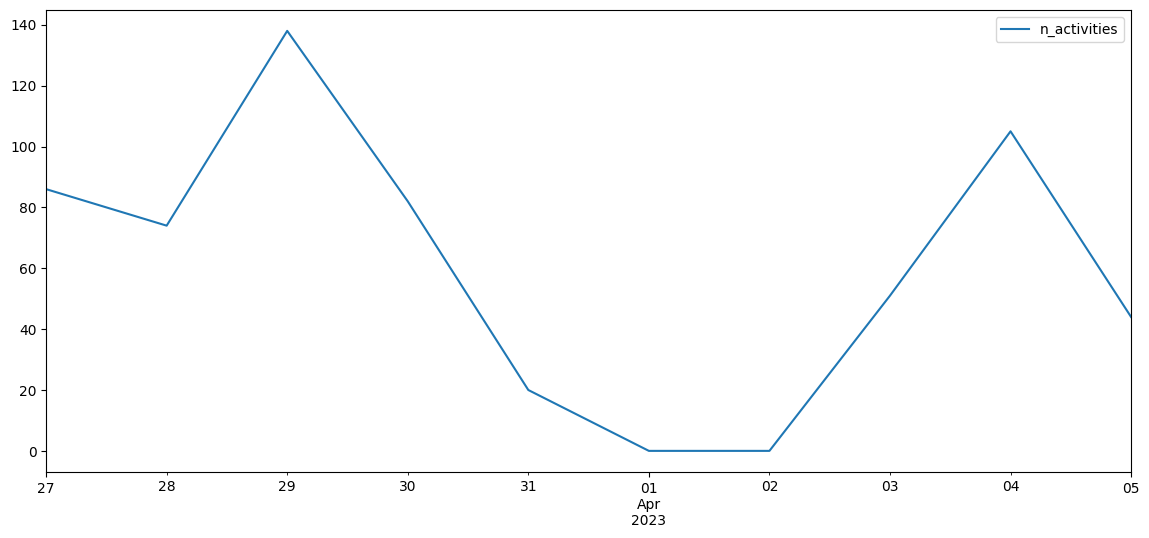

In [9]:
random_name = data['contributor'].sample().values[0]
random_user = data[data['contributor'] == random_name].reset_index(drop=True)

result = (
    random_user
    .groupby([pd.Grouper(key='date', freq='D')])['activity']
    .count()
    .reset_index(name='n_activities')
    .set_index('date')
    .resample('D')
    .sum()
    .rename_axis(None)
)
result.plot(figsize=(14, 6))

## 1. Mean approach

Find the frequency based on the mean of time differences between activities

In [10]:
def mean_based_frequency(contributor):
    train_data = contributor.head(300)
    train_data = train_data[train_data['date'] >= train_data['date'].max() - pd.DateOffset(months=3)]
    time_range = (train_data['date'].iloc[-1] - train_data['date'].iloc[0]).total_seconds()//len(train_data)
    frequency = map_frequency(time_range)
    return frequency

In [11]:
# Example usage:
print("Frequence is :", mean_based_frequency(random_user))

Frequence is : 12T


## 2. Quantile approach

Find the frequency based on the median of time differences between activities

In [12]:
def quantile_based_frequency(contributor, quantile=0.5):
    train_data = contributor.head(300)
    train_data = train_data[train_data['date'] >= train_data['date'].max() - pd.DateOffset(months=3)]
    train_data['time_diff'] = train_data['date'].diff().dt.total_seconds()
    time_range = train_data['time_diff'].quantile(quantile)
    frequency = map_frequency(time_range)
    return frequency

In [13]:
# Example usage:
print("Frequence is :", quantile_based_frequency(random_user, quantile=0.5))

Frequence is : 1T


## 3. Smallest time approach

Find the frequency based on the smallest time to do a specified number of activities (= 100) by sliding over the data

In [14]:
def smallest_time_based_frequency(contributor, window_size=100):
    train_data = contributor.head(300)
    train_data = train_data[train_data['date'] >= train_data['date'].max() - pd.DateOffset(months=3)]

    smallest_time = None
    # iterate over contributor's data in a sliding window
    for i in range(len(train_data) - window_size + 1):
        window = train_data.iloc[i:i + window_size]
        time_span = window['date'].iloc[-1] - window['date'].iloc[0]

        # the smallest time span
        if smallest_time is None or time_span < smallest_time:
            smallest_time = time_span

    time_range = smallest_time.total_seconds()//window_size

    frequency = map_frequency(time_range)

    return frequency

In [15]:
# Example usage:
print("Frequence is :", smallest_time_based_frequency(random_user, window_size=100))

Frequence is : 1T


# Data splitting

In [16]:
def split_activities(contributor, frequency):

    result = (
        contributor
        .groupby([pd.Grouper(key='date', freq=frequency)])['activity']
        .count()
        .reset_index(name='n_activities')
        .set_index('date')
        .resample(frequency)
        .sum()
        .rename_axis(None)
        .assign(
            cumsum_activities = lambda x: x['n_activities'].cumsum()
        )
    )

    train, test = (
        result[result['cumsum_activities'] <= 300]
        .apply(lambda x : x[x.index >= x.index.max() - pd.DateOffset(months=3)])
        .drop('cumsum_activities', axis=1),

        result[result['cumsum_activities'] > 300]
        .drop('cumsum_activities', axis=1)
    )

    return train, test

# Evaluation metrics & tools

In [17]:
def ctd_score(y_true, y_pred, target_value):
    true_cumsum = np.cumsum(y_true)
    pred_cumsum = np.cumsum(y_pred)

    if np.sum(y_pred) < target_value or np.sum(y_true) < target_value:
        return None

    time_true = np.argmax(true_cumsum >= target_value)
    time_pred = np.argmax(pred_cumsum >= target_value)

    return time_true - time_pred

Converts a frequency string (e.g., '1H', '4H', '30T', '20T', '1D') to minutes.

In [33]:
def frequency_to_minutes(frequency):
    mapping = {'T': 1, 'H': 60, 'D': 1440}
    num, unit = int(frequency[:-1]), frequency[-1]
    return num * mapping.get(unit, 1)

In [35]:
frequency_to_minutes('3S')

3

# SARIMA model

In [18]:
def sarima_model(contributor):

    contributor_name = contributor['contributor'].iloc[0]
    contributor_category = contributor['category'].iloc[0]

    frequency = mean_based_frequency(contributor)
    seasonality = frequency_to_seasonality(frequency)

    train, test = split_activities(contributor, frequency)

    print(contributor_name, frequency, seasonality)

    # choosing best parameters (possible seasonality)
    if seasonality and (len(train)//seasonality) >= 2:
        order = (1, 1, 1)
        seasonal_order = (1, 1, 1, seasonality)
    else:
        order = (int((len(train)/3)), 1, 0)
        seasonal_order = None
        seasonality = None

    model = SARIMAX(
        train['n_activities'],
        order = order,
        seasonal_order = seasonal_order, 
        enforce_invertibility = True, 
        enforce_stationarity = False
        ).fit(disp=False, method='lbfgs')

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    metrics = pd.Series({
        'contributor': contributor_name,
        'category': contributor_category,
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'frequency': frequency,
        'seasonality':seasonality,
        'data_points':len(train),
    })

    return metrics

In [19]:
sarima_results = data.groupby(['category', 'contributor']).apply(sarima_model).reset_index(drop=True)

0crat 1H 24
AppVeyorBot 1H 24
Code-Inside-Bot 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CrowdinBot 1H 24
DrahtBot 1H 24
PJBot 4H 6
addonsbot 4H 6
adobe-bot 3T 480


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


agones-bot 1H 24
alluxio-bot 2H 12


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


analysis-bot 3H 8
angular-automatic-lock-bot[bot] 30T 48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ansibot 2H 12
apmmachine 20T 72
aporeto-bot 1H 24
aws-cdk-automation 3T 480
backportbot-nextcloud[bot] 30T 48
ballerina-bot 10T 144


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bedevere-bot 1H 24
bits-bot 3H 8
blathers-crl[bot] 7T 192
bluespice-github-bot 1H 24
boring-cyborg[bot] 1H 24
bors-servo 30T 48
bot-gradle 20T 72
carsonbot 4H 6
cf-gitbot 30T 48
cheminfo-bot 1H 24
cla-bot[bot] 30T 48
cmsdmwmbot 4H 6
codeclimate[bot] 2T 720
codesandbox[bot] 8T 168


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


confs-tech-bot 1H 24
cozy-bot 1H 24
cypress-bot[bot] 1H 24
delete-merged-branch[bot] 4T 360
devOpsHazelcast 30T 48
dlang-bot 2H 12
docker-library-bot 30T 48
dontcallmedom-bot 1H 24
dotnet-bot 15T 96


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


dotnet-issue-labeler[bot] 1H 24
dotnet-maestro-bot 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


edx-requirements-bot 15T 96


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


edx-transifex-bot 1H 24
elife-bot 20T 72
engine-flutter-autoroll 20T 72


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


fire-bot 4H 6
flinkbot 20T 72
fluttergithubbot 30T 48
forking-renovate[bot] 30T 48
fossabot 1H 24
garybot2 4H 6
gatsby-cloud[bot] 20T 72
getsentry-bot 1H 24
gitguardian[bot] 10T 144


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


gitpod-io[bot] 30T 48
google-ml-butler[bot] 1H 24
google-oss-bot 20T 72
graalvmbot 20T 72
graviteeio 30T 48
guardrails[bot] 30T 48
hashicorp-cla 1H 24
hasura-bot 1H 24
hft-team-city 1H 24
ibmdotcom-bot 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ionitron-bot[bot] 3H 8
istio-policy-bot 1H 24
jbosstm-bot 2H 12
jenkins-x-bot-test 6H 4
jetstack-bot 30T 48
jitsi-jenkins 30T 48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


johnpbloch-bot 2H 12
jujubot 4H 6
knative-prow-robot 3H 8
ks-ci-bot 1H 24
kubevirt-commenter-bot 1H 24
lgtm-com[bot] 4T 360
lingohub[bot] 2H 12
linux-foundation-easycla[bot] 30T 48
livingdocs-automation 1H 24
mender-test-bot 1H 24
metal3-io-bot 30T 48
metamaskbot 30T 48
minikube-bot 2H 12
minikube-pr-bot 3H 8
minio-trusted 1H 24
miss-islington 1H 24
mister-roboto 1H 24
mm-cloud-bot 30T 48
moz-wptsync-bot 1H 24
mumukibot 12T 120


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


nacho-bot 1H 24
neos-bot 3H 8
netkan-bot 1H 24
nextcloud-bot 20T 72


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ninjadotorg-bot 1H 24
niveristand-diff-bot 30T 48
nodebb-misty 4H 6
nodejs-github-bot 20T 72
nur-bot 30T 48
octokit-fixture-user-a 30T 48
octokitbot 1H 24
oll-bot 1H 24
openhab-bot 20T 72
openshift-cherrypick-robot 4T 360
openssl-machine 1H 24
pantheon-ci-bot 1H 24
pdfjsbot 1H 24
pirate-bot 1H 24
pivotal-cla 4H 6
pytorchbot 1H 24
qmk-bot 1H 24
r-ryantm 4T 360
release-drafter[bot] 3H 8
renovate-approve-2[bot] 3T 480
repo-ranger[bot] 30T 48
restyled-io[bot] 1T 1440
review-notebook-app[bot] 20T 72
robot-clickhouse 1H 24
rultor 20T 72


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


rust-timer 20T 72
rustbot 30T 48
sagemaker-bot 20T 72
salesforce-cla[bot] 4H 6
scrutinizer-notifier 1H 24
sentry-io[bot] 1H 24
similar-code-searcher[bot] 2H 12
skia-flutter-autoroll 20T 72
softwarefactory-project-zuul[bot] 30T 48
soloio-bot 1H 24
sourcegraph-bot 3T 480
spinnakerbot 2H 12
spring-builds 4H 6
sprucelabs-ci 8T 168


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


sre-bot 1H 24
stakater-user 30T 48
status-im-auto 30T 48
submariner-bot 20T 72
swift-ci 7T 192
taichi-gardener 1H 24
thundernest-bot 4H 6
translatewiki 1H 24
tykbot[bot] 3H 8
usercont-release-bot 30T 48
va-bot 3H 8
vc-ci 20T 72


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


violinist-bot 30T 48
vmwclabot 1H 24
vscode-issue-tracker-bot 30T 48
vtex-io-ci-cd[bot] 1H 24
vtex-io-docs-bot[bot] 2H 12
welcome[bot] 20T 72
wet-boew-bot 4H 6
wso2-jenkins-bot 30T 48
ADmad 3H 8
Bernardo-MG 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Gerrit0 4H 6
Kikobeats 30T 48
Kukks 1H 24
LukeTowers 3H 8
NathanWalker 2H 12
Rotzbua 1H 24
StevenMaude 1H 24
Stranger6667 1H 24
ababic 1H 24
achingbrain 30T 48
adamhsparks 1H 24
alanhamlett 2H 12
alexanderbez 1H 24
althonos 2H 12
am-kantox 4H 6
andreubotella 3H 8
anthrotype 30T 48
antonmedv 1H 24
azat 1H 24
bendrucker 2H 12
betatim 1H 24
bluca 30T 48
bradymholt 3H 8
cboettig 1H 24
cchantep 2H 12
cdepillabout 4H 6
chalin 30T 48
codebytere 1H 24
daffl 1H 24
dantleech 1H 24
darrachequesne 1H 24
davidv1992 2H 12
dbaeumer 1H 24
dbu 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


dbwiddis 30T 48
dereuromark 1H 24
dmage 3H 8
dpvc 1H 24
edsu 2H 12
eduardo-rodrigues 3H 8
ekohl 30T 48
ericholscher 1H 24
ericsoderberghp 1H 24
fax4ever 4H 6


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


gregturn 1H 24
gsmet 30T 48
istarkov 1H 24
jacogr 30T 48
jakirkham 1H 24
jaraco 1H 24
jaredallard 1H 24
jennybc 1H 24
jeremyf 1H 24
kaczmarj 1H 24
keithamus 1H 24
kitten 30T 48
leleuj 1H 24
lirantal 1H 24
ljharb 30T 48
llvm-beanz 3H 8
lmangani 1H 24
lukasgraf 1H 24
maraino 1H 24
markets 2H 12
martinRenou 1H 24
matthewp 1H 24
mattstauffer 1H 24
medikoo 30T 48
mmstick 1H 24
mnapoli 1H 24
mvz 3H 8
nblumhardt 4H 6
nicoddemus 1H 24
nikku 1H 24
norkans7 2H 12
nytamin 4H 6
p0nce 2H 12
parlough 30T 48
paulfalgout 1H 24
petemoore 2H 12
petersilva 4H 6
phax 1H 24
philippfromme 3H 8
raphaelm 1H 24
rasheedamir 4H 6


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


reckart 1H 24
rixx 3H 8
rminnich 3H 8
seratch 1H 24
sfackler 3H 8
shawnbot 4H 6
snakefoot 1H 24
sonnyp 1H 24
sserrata 1H 24
staltz 1H 24
stapelberg 1H 24
suzuki-shunsuke 20T 72


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


techknowlogick 30T 48
tibetsprague 2H 12
timja 30T 48
tommoor 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


tschaub 2H 12
twiecki 3H 8
tychoish 2H 12


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ueokande 1H 24
unknwon 30T 48
vasturiano 8T 168


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


visualfc 1H 24
vmarkovtsev 30T 48
yajra 2H 12
yowainwright 1H 24
yuce 1H 24
yurishkuro 30T 48


In [20]:
sarima_results.to_csv('../models-evaluation/sarima_model-mean-v1.csv', index=False)

# Unobserved components model

In [21]:
def uc_model(contributor):

    contributor_name = contributor['contributor'].iloc[0]
    contributor_category = contributor['category'].iloc[0]

    frequency = mean_based_frequency(contributor)
    seasonality = frequency_to_seasonality(frequency)

    train, test = split_activities(contributor, frequency)

    print(contributor_name, frequency, seasonality)

    # choosing best parameters (possible seasonality)
    if (len(train)//seasonality) < 2:
        seasonality = None

    model = UnobservedComponents(
        train['n_activities'], 
        level = True, 
        seasonal = seasonality
        ).fit(disp=False, method='lbfgs')
    
    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    metrics = pd.Series({
        'contributor': contributor_name,
        'category': contributor_category,
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'frequency': frequency,
        'seasonality':seasonality,
        'data_points':len(train),
    })

    return metrics

In [22]:
uc_results = data.groupby(['category', 'contributor']).apply(uc_model).reset_index(drop=True)

0crat 1H 24
AppVeyorBot 1H 24
Code-Inside-Bot 1H 24
CrowdinBot 1H 24
DrahtBot 1H 24
PJBot 4H 6
addonsbot 4H 6
adobe-bot 3T 480
agones-bot 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


alluxio-bot 2H 12
analysis-bot 3H 8
angular-automatic-lock-bot[bot] 30T 48
ansibot 2H 12
apmmachine 20T 72
aporeto-bot 1H 24
aws-cdk-automation 3T 480
backportbot-nextcloud[bot] 30T 48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


ballerina-bot 10T 144
bedevere-bot 1H 24
bits-bot 3H 8
blathers-crl[bot] 7T 192
bluespice-github-bot 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


boring-cyborg[bot] 1H 24
bors-servo 30T 48
bot-gradle 20T 72
carsonbot 4H 6
cf-gitbot 30T 48
cheminfo-bot 1H 24
cla-bot[bot] 30T 48
cmsdmwmbot 4H 6
codeclimate[bot] 2T 720
codesandbox[bot] 8T 168


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


confs-tech-bot 1H 24
cozy-bot 1H 24
cypress-bot[bot] 1H 24
delete-merged-branch[bot] 4T 360
devOpsHazelcast 30T 48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


dlang-bot 2H 12
docker-library-bot 30T 48
dontcallmedom-bot 1H 24
dotnet-bot 15T 96
dotnet-issue-labeler[bot] 1H 24
dotnet-maestro-bot 1H 24
edx-requirements-bot 15T 96
edx-transifex-bot 1H 24
elife-bot 20T 72
engine-flutter-autoroll 20T 72
fire-bot 4H 6
flinkbot 20T 72
fluttergithubbot 30T 48
forking-renovate[bot] 30T 48
fossabot 1H 24
garybot2 4H 6
gatsby-cloud[bot] 20T 72
getsentry-bot 1H 24
gitguardian[bot] 10T 144
gitpod-io[bot] 30T 48
google-ml-butler[bot] 1H 24
google-oss-bot 20T 72
graalvmbot 20T 72
graviteeio 30T 48
guardrails[bot] 30T 48
hashicorp-cla 1H 24
hasura-bot 1H 24
hft-team-city 1H 24
ibmdotcom-bot 1H 24
ionitron-bot[bot] 3H 8
istio-policy-bot 1H 24
jbosstm-bot 2H 12
jenkins-x-bot-test 6H 4
jetstack-bot 30T 48
jitsi-jenkins 30T 48
johnpbloch-bot 2H 12
jujubot 4H 6
knative-prow-robot 3H 8
ks-ci-bot 1H 24
kubevirt-commenter-bot 1H 24
lgtm-com[bot] 4T 360


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


lingohub[bot] 2H 12
linux-foundation-easycla[bot] 30T 48
livingdocs-automation 1H 24
mender-test-bot 1H 24
metal3-io-bot 30T 48
metamaskbot 30T 48
minikube-bot 2H 12
minikube-pr-bot 3H 8
minio-trusted 1H 24
miss-islington 1H 24
mister-roboto 1H 24
mm-cloud-bot 30T 48
moz-wptsync-bot 1H 24
mumukibot 12T 120
nacho-bot 1H 24
neos-bot 3H 8
netkan-bot 1H 24
nextcloud-bot 20T 72
ninjadotorg-bot 1H 24
niveristand-diff-bot 30T 48
nodebb-misty 4H 6
nodejs-github-bot 20T 72
nur-bot 30T 48
octokit-fixture-user-a 30T 48
octokitbot 1H 24
oll-bot 1H 24
openhab-bot 20T 72
openshift-cherrypick-robot 4T 360
openssl-machine 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


pantheon-ci-bot 1H 24
pdfjsbot 1H 24
pirate-bot 1H 24
pivotal-cla 4H 6
pytorchbot 1H 24
qmk-bot 1H 24
r-ryantm 4T 360
release-drafter[bot] 3H 8
renovate-approve-2[bot] 3T 480
repo-ranger[bot] 30T 48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


restyled-io[bot] 1T 1440
review-notebook-app[bot] 20T 72


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


robot-clickhouse 1H 24
rultor 20T 72
rust-timer 20T 72
rustbot 30T 48
sagemaker-bot 20T 72
salesforce-cla[bot] 4H 6
scrutinizer-notifier 1H 24
sentry-io[bot] 1H 24
similar-code-searcher[bot] 2H 12
skia-flutter-autoroll 20T 72
softwarefactory-project-zuul[bot] 30T 48
soloio-bot 1H 24
sourcegraph-bot 3T 480


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


spinnakerbot 2H 12
spring-builds 4H 6
sprucelabs-ci 8T 168
sre-bot 1H 24
stakater-user 30T 48
status-im-auto 30T 48
submariner-bot 20T 72
swift-ci 7T 192
taichi-gardener 1H 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


thundernest-bot 4H 6
translatewiki 1H 24
tykbot[bot] 3H 8
usercont-release-bot 30T 48
va-bot 3H 8
vc-ci 20T 72
violinist-bot 30T 48
vmwclabot 1H 24
vscode-issue-tracker-bot 30T 48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


vtex-io-ci-cd[bot] 1H 24
vtex-io-docs-bot[bot] 2H 12
welcome[bot] 20T 72
wet-boew-bot 4H 6
wso2-jenkins-bot 30T 48
ADmad 3H 8
Bernardo-MG 1H 24
Gerrit0 4H 6
Kikobeats 30T 48
Kukks 1H 24
LukeTowers 3H 8
NathanWalker 2H 12
Rotzbua 1H 24
StevenMaude 1H 24
Stranger6667 1H 24
ababic 1H 24
achingbrain 30T 48
adamhsparks 1H 24
alanhamlett 2H 12
alexanderbez 1H 24
althonos 2H 12
am-kantox 4H 6
andreubotella 3H 8
anthrotype 30T 48
antonmedv 1H 24
azat 1H 24
bendrucker 2H 12
betatim 1H 24
bluca 30T 48
bradymholt 3H 8
cboettig 1H 24
cchantep 2H 12
cdepillabout 4H 6
chalin 30T 48
codebytere 1H 24
daffl 1H 24
dantleech 1H 24
darrachequesne 1H 24
davidv1992 2H 12
dbaeumer 1H 24
dbu 1H 24
dbwiddis 30T 48
dereuromark 1H 24
dmage 3H 8
dpvc 1H 24
edsu 2H 12
eduardo-rodrigues 3H 8
ekohl 30T 48
ericholscher 1H 24
ericsoderberghp 1H 24
fax4ever 4H 6
gregturn 1H 24
gsmet 30T 48
istarkov 1H 24
jacogr 30T 48
jakirkham 1H 24
jaraco 1H 24
jaredallard 1H 24
jennybc 1H 24
jeremyf 1H 24
kaczmarj 1H 24
keithamus 1H

In [23]:
uc_results.to_csv('../models-evaluation/uc_model-mean-v1.csv', index=False)

# Error Trend and Seasonality model

In [53]:
def ets_model(contributor):

    contributor_name = contributor['contributor'].iloc[0]
    contributor_category = contributor['category'].iloc[0]

    frequency = quantile_based_frequency(contributor, quantile=0.85)
    seasonality = frequency_to_seasonality(frequency)

    train, test = split_activities(contributor, frequency)

    print(contributor_name, frequency, seasonality)

    # choosing best parameters (possible seasonality)
    if seasonality and (len(train)//seasonality) >= 2:
        seasonal = 'add'
    else:
        seasonality = None
        seasonal = None

    model = ETSModel(
        train['n_activities'], 
        error = 'add', 
        trend = 'add', 
        seasonal = seasonal, 
        seasonal_periods = seasonality
    ).fit(disp=False)

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    metrics = pd.Series({
        'contributor': contributor_name,
        'category': contributor_category,
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'frequency': frequency,
        'seasonality':seasonality,
        'data_points':len(train),
    })

    return metrics

In [ ]:
ets_results = data.groupby(['category', 'contributor']).apply(ets_model).reset_index(drop=True)

In [51]:
contributor = data[data['contributor'] == '0crat']
frequency = quantile_based_frequency(contributor, quantile=0.85)
frequency

'1H'

In [52]:
train, test = split_activities(contributor, frequency)
display(train.tail(60))

,n_activities
2022-12-13 12:00:00+00:00,1
2022-12-13 13:00:00+00:00,1
2022-12-13 14:00:00+00:00,0
2022-12-13 15:00:00+00:00,0
2022-12-13 16:00:00+00:00,3
2022-12-13 17:00:00+00:00,8
2022-12-13 18:00:00+00:00,2
2022-12-13 19:00:00+00:00,16
2022-12-13 20:00:00+00:00,3
2022-12-13 21:00:00+00:00,1


In [ ]:
ets_results.to_csv('../models-evaluation/ets_model-quantile-85-v1.csv', index=False)